# High-Dimensional-Deep-Learning
## Mini-project n° 4– RNN, LSTM and GRU vs MLP and CNN

###  Maddie Perez, Julia Soufflet, Maïmouna Gadji et Phuc-Luan Nguyen

L'objectif de ce mini-projet est de comparer un RNN, un LSTM et un GRU, ainsi que les modèles plus traditionnels comme le MLP et le CNN, sur le dataset IMDB pour la tâche d'analyse de sentiments. Cela signifie qu'à partir des commentaires sur les films dans le dataset IMDB, nous cherchons à construire un modèle capable d'évaluer si un commentaire est positif ou négatif.

Pour réaliser la comparaison entre ces modèles, il est nécessaire d'expliquer et d'évaluer :

+ Le choix des architectures : les types de couches, les tailles des couches et les fonctions d'activation.
+ Le choix des hyperparamètres : taille des lots (batch size), taux d'apprentissage (learning rate), nombre d'époques (epochs), poids de régularisation...
+ Le choix de la fonction de perte (loss function).
+ Comparer le temps d'exécution des différents modèles, leur empreinte mémoire et leur précision. Quelles conclusions pouvez-vous en tirer ?



RNN (Réseau de Neurones Récurrents) : Les RNN sont un choix naturel pour les données séquentielles comme le texte, car ils traitent les entrées un élément à la fois et maintiennent un état caché qui capture des informations provenant des étapes précédentes de la séquence. Cependant, les RNN sont sujets aux problèmes de gradients disparus ou explosés, ce qui les rend plus difficiles à entraîner sur des séquences longues.

LSTM (Long Short-Term Memory) : Les LSTMs résolvent le problème des gradients disparus en introduisant des cellules mémoire qui peuvent stocker des informations sur de longues périodes. Cela rend les LSTMs particulièrement adaptés pour des tâches comme l'analyse de sentiment, où des dépendances à long terme (par exemple, le sentiment global d'une critique) sont cruciales.

GRU (Gated Recurrent Unit) : Les GRUs sont une variation des LSTMs avec une architecture plus simple (moins de portes). Ils ont souvent des performances similaires à celles des LSTMs mais sont moins coûteux en termes de calcul, ce qui en fait un bon choix pour un entraînement plus rapide.

MLP (Multilayer Perceptron) : Un MLP est un réseau de neurones entièrement connecté qui peut être utilisé pour toute tâche de prédiction, y compris l'analyse de sentiments. Il ne gère pas de manière inhérente les données séquentielles comme les RNNs ou LSTMs, mais en utilisant des techniques comme le bag-of-words ou des embeddings de mots, les MLPs peuvent quand même bien performer sur des tâches de classification de texte.

CNN (Convolutional Neural Network) : Bien que les CNNs soient traditionnellement utilisés pour la classification d'images, ils peuvent également être appliqués au texte en utilisant des convolutions 1D. Cette architecture peut capturer des motifs locaux dans le texte (par exemple, des n-grams) et a montré qu'elle fonctionne efficacement pour les tâches de classification de texte.

## I. Importation des données

In [1]:
import os
import pandas as pd

In [2]:
# Définir le chemin du dossier principal contenant les données
base_dir = 'IMDB_dataset' 

# Initialiser les DataFrames vides pour les ensembles d'entraînement, de test et non étiquetés
train_df = pd.DataFrame(columns=["text", "label"])
test_df = pd.DataFrame(columns=["text", "label"])
unlabeled_data = pd.DataFrame(columns=["text"])

# Parcourir les dossiers train et test pour charger les fichiers étiquetés
for folder in ['train', 'test']:
    for sentiment in ['pos', 'neg']:
        # Créer le chemin complet pour chaque dossier (pos/neg)
        sentiment_folder = os.path.join(base_dir, folder, sentiment)
        
        # Initialiser une liste pour stocker les données de chaque dossier
        texts = []
        labels = []
        
        # Parcourir tous les fichiers .txt dans le dossier
        for filename in os.listdir(sentiment_folder):
            if filename.endswith('.txt'):
                # Créer le chemin complet du fichier
                file_path = os.path.join(sentiment_folder, filename)
                
                # Ouvrir le fichier et lire son contenu
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read()  # Lire tout le contenu du fichier
                
                # Ajouter le texte et l'étiquette correspondante à la liste
                texts.append(text)
                labels.append(1 if sentiment == 'pos' else 0)  # 1 pour positif, 0 pour négatif
        
        # Créer un DataFrame pour le dossier actuel
        temp_df = pd.DataFrame({"text": texts, "label": labels})
        
        # Ajouter les données au DataFrame d'entraînement ou de test
        if folder == 'train':
            train_df = pd.concat([train_df, temp_df], ignore_index=True)
        elif folder == 'test':
            test_df = pd.concat([test_df, temp_df], ignore_index=True)

# Traiter les données non étiquetées dans le dossier 'train/unsup'
unsup_folder = os.path.join(base_dir, 'train', 'unsup')

# Initialiser une liste pour les textes non étiquetés
unlabeled_texts = []

# Parcourir tous les fichiers .txt dans le dossier unsup
for filename in os.listdir(unsup_folder):
    if filename.endswith('.txt'):
        # Créer le chemin complet du fichier
        file_path = os.path.join(unsup_folder, filename)
        
        # Ouvrir le fichier et lire son contenu
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()  # Lire tout le contenu du fichier
        
        # Ajouter le texte à la liste des données non étiquetées
        unlabeled_texts.append(text)

# Créer un DataFrame pour les données non étiquetées
unlabeled_data = pd.DataFrame({"text": unlabeled_texts})

In [2]:
# Chargement des DataFrames depuis un fichier CSV
train_df = pd.read_csv("train_data.csv", encoding='utf-8')
test_df = pd.read_csv("test_data.csv", encoding='utf-8')
unlabeled_data = pd.read_csv("unlabeled_data.csv", encoding='utf-8')


## II. Prétraitement des données

### II. 1. Exploitation des données

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


# Vérifier la taille des DataFrames et afficher le nombre de "pos" et "neg"
print(f"Nombre d'exemples dans le train set : {train_df.shape[0]}")  # Nombre d'exemples d'entraînement
print(f"Nombre d'exemples dans le test set : {test_df.shape[0]}")    # Nombre d'exemples de test
print(f"Nombre d'exemples non étiquetés dans le train/unsup : {unlabeled_data.shape[0]}")  # Nombre de données non étiquetées

Nombre d'exemples dans le train set : 21168
Nombre d'exemples dans le test set : 24678
Nombre d'exemples non étiquetés dans le train/unsup : 49507


In [4]:
train_df.head()

,text,label
0,"Roeg has done some great movies, but this a tu...",0
1,I can't believe I've just spent one and a half...,0
2,"I really wanted to like this western, being a ...",0
3,"A pale shadow of a great musical, this movie s...",0
4,This is a horrible little film--and unfortunat...,0


In [5]:
unlabeled_data.head()

,text
0,"I admit, the great majority of films released ..."
1,"Take a low budget, inexperienced actors doubli..."
2,"Everybody has seen 'Back To The Future,' right..."
3,Doris Day was an icon of beauty in singing and...
4,"After a series of silly, fun-loving movies, 19..."


In [6]:
# Vérification des valeurs nulles
print("\nVérification des valeurs nulles dans le train set :")
print(train_df.isnull().sum())  # Compte les valeurs nulles dans chaque colonne

print("\nVérification des valeurs nulles dans le test set :")
print(test_df.isnull().sum())  # Compte les valeurs nulles dans chaque colonne

print("\nVérification des valeurs nulles dans les données non étiquetées :")
print(unlabeled_data.isnull().sum())  # Compte les valeurs nulles dans chaque colonne


Vérification des valeurs nulles dans le train set :
text     0
label    0
dtype: int64

Vérification des valeurs nulles dans le test set :
text     0
label    0
dtype: int64

Vérification des valeurs nulles dans les données non étiquetées :
text    0
dtype: int64


In [7]:
# Vérification des doublons
print("\nVérification des doublons dans le train set :")
print(train_df.duplicated().sum())  # Nombre de lignes dupliquées dans le train set

print("\nVérification des doublons dans le test set :")
print(test_df.duplicated().sum())  # Nombre de lignes dupliquées dans le test set

print("\nVérification des doublons dans les données non étiquetées :")
print(unlabeled_data.duplicated().sum())  # Nombre de lignes dupliquées dans les données non étiquetées

# Extraire les textes de l'ensemble train et test
train_texts = train_df["text"]
test_texts = test_df["text"]

# Trouver l'intersection entre les deux ensembles de textes (train et test)
common_texts = set(train_texts).intersection(set(test_texts))

# Afficher le nombre d'éléments communs (intersection)
print(f"\nNombre de commentaires communs entre l'ensemble train et l'ensemble test : {len(common_texts)}")


Vérification des doublons dans le train set :
0

Vérification des doublons dans le test set :
0

Vérification des doublons dans les données non étiquetées :
0

Nombre de commentaires communs entre l'ensemble train et l'ensemble test : 0


In [8]:
# Supprimer les doublons dans train et test
train_df = train_df.drop_duplicates(subset=["text"])
test_df = test_df.drop_duplicates(subset=["text"])
unlabeled_data = unlabeled_data.drop_duplicates(subset=["text"])

# Trouver l'intersection
common_texts = set(train_df["text"]).intersection(set(test_df["text"]))

# Supprimer les commentaires communs dans les deux ensembles
test_df = test_df[~test_df["text"].isin(common_texts)]

# Afficher les tailles après nettoyage
print(f"Train set size after cleaning: {train_df.shape[0]}")
print(f"Test set size after cleaning: {test_df.shape[0]}")

Train set size after cleaning: 21168
Test set size after cleaning: 24678


In [9]:
train_df['label'] = train_df['label'].astype('category')
test_df['label'] = test_df['label'].astype('category')

### II. 2. Division des données 

In [10]:
from sklearn.model_selection import train_test_split

# Diviser les données d'entraînement en train et validation
train_df,val_df = train_test_split(train_df, test_size=0.15, random_state=42)


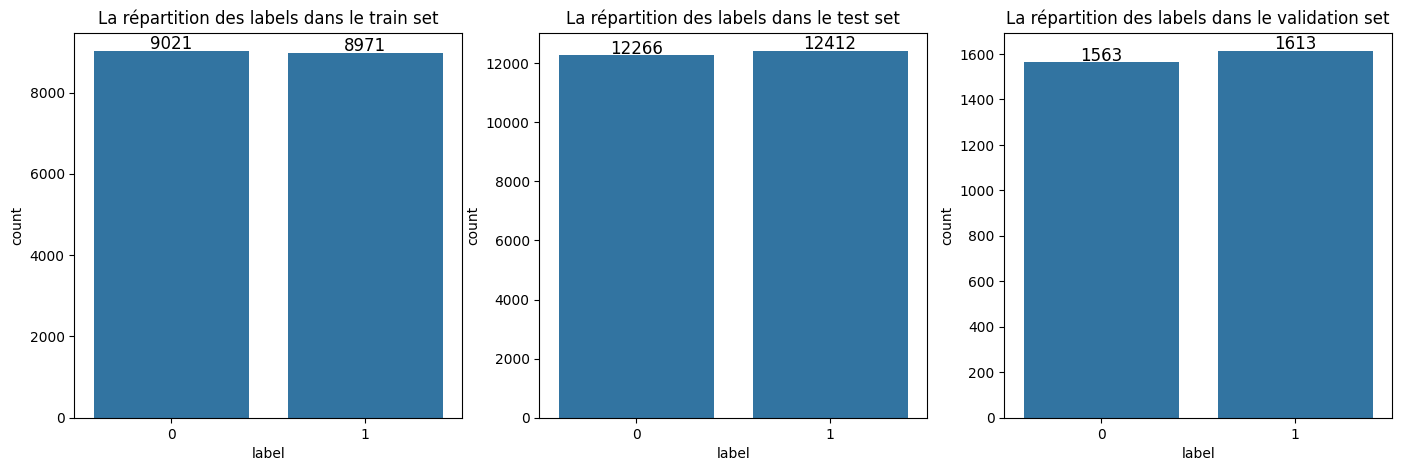

In [11]:
plt.figure(figsize=(17,5))
# Train set
plt.subplot(131)
ax1 = sns.countplot(x=train_df["label"])
plt.title("La répartition des labels dans le train set")
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Test set
plt.subplot(132)
ax2 = sns.countplot(x=test_df["label"])
plt.title("La répartition des labels dans le test set")
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Validation set
plt.subplot(133)
ax3 = sns.countplot(x=val_df["label"])
plt.title("La répartition des labels dans le validation set")
for p in ax3.patches:
    ax3.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')


### II. 3. Représentation du texte

In [12]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

# 1. Appliquer TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)  # Limit to 3000 features
train_tfidf = vectorizer.fit_transform(train_df["text"])
val_tfidf=vectorizer.transform(val_df["text"])
test_tfidf = vectorizer.transform(test_df["text"])


### Essaie Logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(train_tfidf, train_df['label'])

train_score = model.score(train_tfidf,train_df['label'] )
print(train_score)

0.904846598488217


Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12266
           1       0.87      0.88      0.87     12412

    accuracy                           0.87     24678
   macro avg       0.87      0.87      0.87     24678
weighted avg       0.87      0.87      0.87     24678

Confusion Matrix:


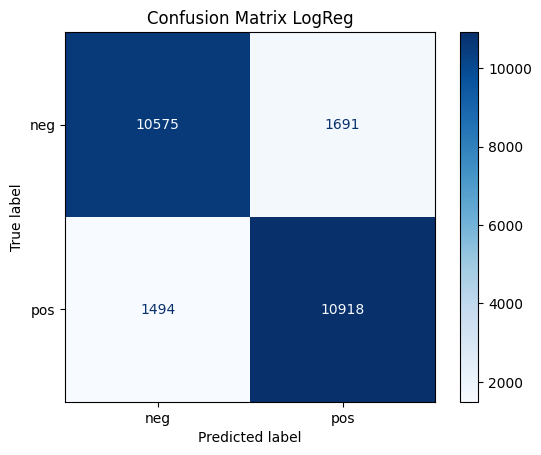

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Prédictions sur les données de test
y_pred = model.predict(test_tfidf)

# Calcul de l'accuracy
accuracy = accuracy_score(test_df["label"], y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Rapport de classification
print("Classification Report:")
print(classification_report(test_df["label"], y_pred))

# Matrice de confusion
print("Confusion Matrix:")
cm = confusion_matrix(test_df["label"], y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix LogReg")
plt.show()

## III. Modélisation

**Sur le choix des architectures :**
+ Les types de couches (layer types) :

        Nous avons choisi les types de couches correspondant aux modèles que nous souhaitons utiliser (RNN, LSTM, GRU, MLP, CNN). En outre, nous avons ajouté des couches de dropout pour éviter le surapprentissage (overfitting).
+ La taille des couches (layer size) :

        Nous avons testé avec 32, 64 et 128 neurones. Nous avons constaté que la précision avec 128 neurones était meilleure (ce qui est assez évident car le modèle est plus complexe). De plus, le temps d'entraînement avec 128 neurones reste raisonnable, ce qui justifie notre choix de cette taille.
        Nous avons décidé d'utiliser 128 neurones pour les modèles RNN, LSTM et GRU afin de pouvoir comparer leur temps d'exécution.
+ Les fonctions d'activation (activations) :

        La couche de sortie utilise une fonction d'activation sigmoïde pour les tâches de classification binaire (sentiment positif ou négatif).

**Sur le choix des hyperparamètres :**

+ Batch size et taux d'apprentissage (learning rate) :

        Nous utiliserons une recherche en grille (grid search) pour trouver les hyperparamètres les plus adaptés et l'appliquerons à tous les modèles afin de comparer leurs temps d'exécution.
+ Nombre d'époques (number of epochs) :

        Nous avons initialement testé avec 50 époques, mais nous avons observé que l'entraînement convergeait assez tôt. Par conséquent, nous avons réduit ce nombre à 30 époques pour réduire le temps d'entraînement, sans impact sur les résultats. Ainsi, nous avons choisi 30 époques.
**Sur le choix de la fonction de perte :**
        Pour les tâches de classification binaire, comme l'analyse de sentiment (positif ou négatif), nous avons utilisé la fonction de perte entropie croisée binaire (binary_crossentropy).


### III.1 RNN

In [15]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
# 1. Tokenisation des données
# Puisque nous avons des données TF-IDF, nous allons les utiliser directement, sans passage par l'Embedding traditionnel
# Nous devons simplement gérer la forme des données pour les utiliser dans le modèle RNN.

# Convertir les données TF-IDF en tableau dense pour que le RNN puisse les prendre en entrée
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()


y_train=train_df['label'].to_numpy()
y_val=val_df['label'].to_numpy()

In [16]:
train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))

In [34]:
# Hyperparamètres à tester
batch_sizes = [32, 64, 128]
learning_rates = [1e-5, 5e-5, 1e-4]

# Liste pour stocker les résultats
resultats = []

# Boucle pour tester toutes les combinaisons de batch_size et learning_rate
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        # Initialisation du modèle
        model_rnn = Sequential()
        model_rnn.add(SimpleRNN(128, activation='tanh', input_shape=(1, train_tfidf_dense.shape[2])))
        model_rnn.add(Dropout(0.2))
        model_rnn.add(Dense(1, activation='sigmoid'))
        
        # Compilation du modèle
        model_rnn.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
        
        # Mesure du temps d'entraînement
        start_time = time.time()
        historique = model_rnn.fit(
            train_tfidf_dense, y_train,
            epochs=30,
            batch_size=batch_size,
            validation_data=(val_tfidf_dense, y_val),
            verbose=0
        )
        end_time = time.time()
        
        # Calcul du temps écoulé et stockage des résultats
        temps_ecoule = end_time - start_time
        val_accuracy = max(historique.history['val_accuracy'])
        
        resultats.append({
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'val_accuracy': val_accuracy,
            'temps': temps_ecoule
        })
        
        print(f"Taille de batch : {batch_size}, Taux d'apprentissage : {learning_rate}, Précision validation : {val_accuracy:.4f}, Temps : {temps_ecoule:.2f}s")

# Conversion des résultats en tableau numpy pour une analyse facile
resultats_array = np.array([[res['batch_size'], res['learning_rate'], res['val_accuracy'], res['temps']] for res in resultats])

Taille de batch : 32, Taux d'apprentissage : 1e-05, Précision validation : 0.8672, Temps : 92.84s
Taille de batch : 32, Taux d'apprentissage : 5e-05, Précision validation : 0.8841, Temps : 92.52s
Taille de batch : 32, Taux d'apprentissage : 0.0001, Précision validation : 0.8836, Temps : 92.98s
Taille de batch : 64, Taux d'apprentissage : 1e-05, Précision validation : 0.8549, Temps : 47.50s


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Nous constatons que la précision des différents paramètres ne varie pas significativement, mais la différence réside principalement dans le temps d'exécution. Cela s'explique par le fait qu'une taille de batch plus grande réduit le nombre total d'itérations d'entraînement (nombre d'itérations = nombre d'époques * (nombre total d'échantillons / taille du batch)).

D'après les résultats obtenus, nous avons choisi une taille de batch de 64. Bien qu'une taille de batch de 128 réduise encore davantage le temps d'entraînement, nous avons remarqué que, dans certains cas, la taille des données utilisées pour une itération dépasse la capacité de mémoire VRAM de notre GPU, ce qui entraîne des erreurs. Par conséquent, une taille de batch de 64 est plus adaptée à notre machine et permet également de réduire considérablement le temps d'entraînement. De plus, nous avons choisi un taux d'apprentissage (learning rate) de 1e-5.

In [17]:
# 2. Construction du modèle RNN
model_rnn = Sequential()

# Ajouter une couche SimpleRNN avec 128 unités
#model_rnn.add(SimpleRNN(128, activation='tanh'))  # Première couche RNN, return_sequences=True permet de passer les séquences à la couche suivante

model_rnn.add(SimpleRNN(128, activation='tanh', input_shape=(1, train_tfidf_dense.shape[2])))


# Dropout pour éviter le surapprentissage
model_rnn.add(Dropout(0.2))

# Couche de sortie pour la classification binaire
model_rnn.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# 3. Compilation du modèle
model_rnn.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               400512    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 400,641
Trainable params: 400,641
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 5. Entraînement du modèle
start_time= time.time()

history=model_rnn.fit(train_tfidf_dense, y_train,
          epochs=30, 
          batch_size=64, 
          validation_data=(val_tfidf_dense, y_val), 
          verbose=1)

end_time=time.time()

time_RNN=end_time - start_time

Epoch 1/30
282/282 [==============================] - 3s 6ms/step - loss: 0.6808 - accuracy: 0.6807 - val_loss: 0.6694 - val_accuracy: 0.7975
Epoch 2/30
282/282 [==============================] - 1s 5ms/step - loss: 0.6556 - accuracy: 0.8115 - val_loss: 0.6451 - val_accuracy: 0.8281
Epoch 3/30
282/282 [==============================] - 1s 5ms/step - loss: 0.6280 - accuracy: 0.8336 - val_loss: 0.6181 - val_accuracy: 0.8419
Epoch 4/30
282/282 [==============================] - 2s 5ms/step - loss: 0.5982 - accuracy: 0.8462 - val_loss: 0.5895 - val_accuracy: 0.8451
Epoch 5/30
282/282 [==============================] - 1s 5ms/step - loss: 0.5679 - accuracy: 0.8518 - val_loss: 0.5611 - val_accuracy: 0.8470
Epoch 6/30
282/282 [==============================] - 2s 5ms/step - loss: 0.5378 - accuracy: 0.8552 - val_loss: 0.5338 - val_accuracy: 0.8492
Epoch 7/30
282/282 [==============================] - 1s 5ms/step - loss: 0.5096 - accuracy: 0.8582 - val_loss: 0.5080 - val_accuracy: 0.8517
Epoch 

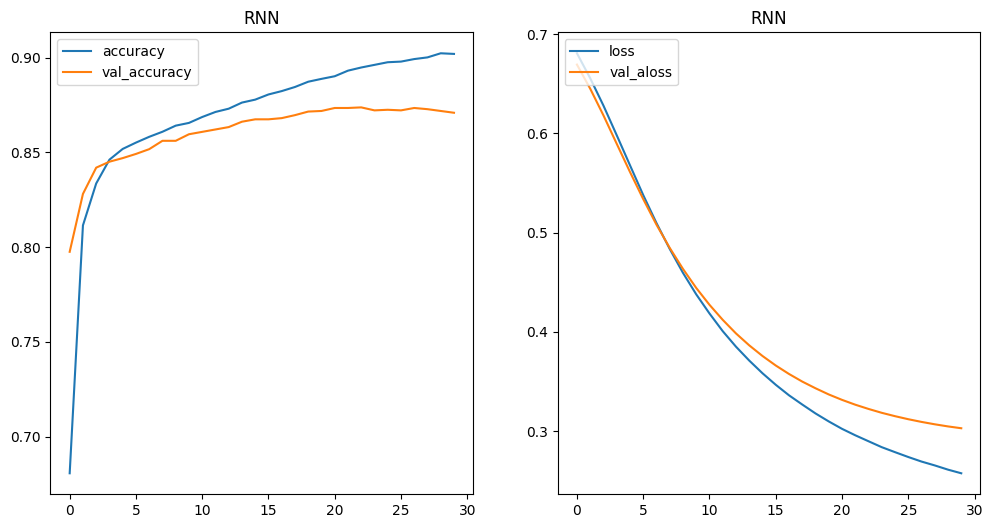

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("RNN")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_aloss')
plt.title("RNN")
plt.legend(loc='upper left')
plt.show()

In [20]:
# Reshape test data to 3D (batch_size, timesteps, features)
##test_tfidf_reshaped = np.expand_dims(test_tfidf.toarray(), axis=-1)
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))
# Evaluate the model
loss_rnn, accuracy_rnn = model_rnn.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Display results
print(f"Test Loss: {loss_rnn:.4f}, Test Accuracy: {accuracy_rnn:.4f}")


772/772 [==============================] - 2s 3ms/step - loss: 0.3043 - accuracy: 0.8739
Test Loss: 0.3043, Test Accuracy: 0.8739


772/772 [==============================] - 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12266
           1       0.87      0.88      0.88     12412

    accuracy                           0.87     24678
   macro avg       0.87      0.87      0.87     24678
weighted avg       0.87      0.87      0.87     24678



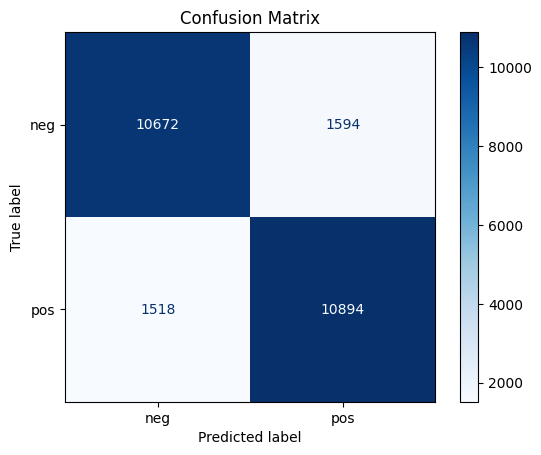

In [21]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_rnn.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [22]:
duration={}
accuracy={}

In [23]:
duration["RNN"] = time_RNN
accuracy["RNN"] = accuracy_rnn

In [24]:
duration,accuracy

({'RNN': 48.372605323791504}, {'RNN': 0.8738957643508911})

### III.2 LSTM

In [25]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()

In [26]:
# 2. Construction du modèle RNN
model_lstm = Sequential()

# Ajouter une couche SimpleRNN avec 64 unités
model_lstm.add(LSTM(128, activation='tanh',input_shape=(1, train_tfidf_dense.shape[1])))  # Première couche LSTM, return_sequences=True permet de passer les séquences à la couche suivante



# Dropout pour éviter le surapprentissage
model_lstm.add(Dropout(0.2))

# Couche de sortie pour la classification binaire
model_lstm.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# 3. Compilation du modèle
model_lstm.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])


model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               1602048   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,602,177
Trainable params: 1,602,177
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 4. Reshaper les données d'entrée
train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))

start_time= time.time()
# 5. Entraînement du modèle
history=model_lstm.fit(train_tfidf_dense, y_train,
          epochs=30, 
          batch_size=64, 
          validation_data=(val_tfidf_dense, y_val), 
          verbose=1)

end_time=time.time()

time_LSTM=end_time - start_time

Epoch 1/30
282/282 [==============================] - 5s 8ms/step - loss: 0.6901 - accuracy: 0.6575 - val_loss: 0.6870 - val_accuracy: 0.7667
Epoch 2/30
282/282 [==============================] - 2s 6ms/step - loss: 0.6827 - accuracy: 0.7968 - val_loss: 0.6794 - val_accuracy: 0.8035
Epoch 3/30
282/282 [==============================] - 2s 6ms/step - loss: 0.6734 - accuracy: 0.8235 - val_loss: 0.6697 - val_accuracy: 0.8186
Epoch 4/30
282/282 [==============================] - 2s 6ms/step - loss: 0.6616 - accuracy: 0.8298 - val_loss: 0.6574 - val_accuracy: 0.8271
Epoch 5/30
282/282 [==============================] - 2s 6ms/step - loss: 0.6470 - accuracy: 0.8382 - val_loss: 0.6427 - val_accuracy: 0.8325
Epoch 6/30
282/282 [==============================] - 2s 6ms/step - loss: 0.6300 - accuracy: 0.8430 - val_loss: 0.6256 - val_accuracy: 0.8356
Epoch 7/30
282/282 [==============================] - 2s 6ms/step - loss: 0.6105 - accuracy: 0.8467 - val_loss: 0.6065 - val_accuracy: 0.8385
Epoch 

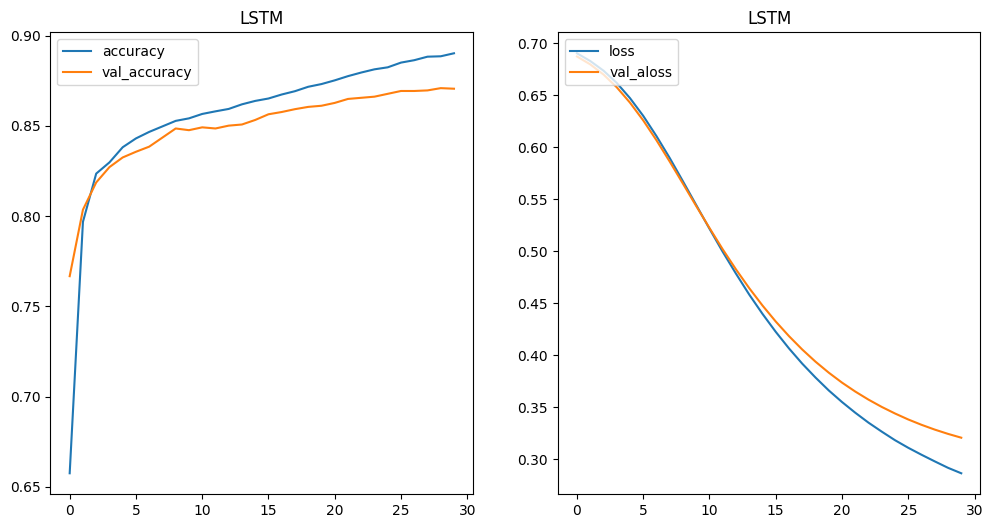

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("LSTM")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_aloss')
plt.title("LSTM")
plt.legend(loc='upper left')
plt.show()

In [29]:
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))

# Maintenant vous pouvez appeler le modèle avec les données correctement redimensionnées
loss_LSTM, accuracy_LSTM = model_lstm.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Afficher les résultats
print(f"Test Loss: {loss_LSTM:.4f}, Test Accuracy: {accuracy_LSTM:.4f}")


772/772 [==============================] - 3s 3ms/step - loss: 0.3218 - accuracy: 0.8691
Test Loss: 0.3218, Test Accuracy: 0.8691


In [30]:
duration["LSTM"] = time_LSTM
accuracy["LSTM"] = accuracy_LSTM

In [31]:
duration, accuracy

({'RNN': 48.372605323791504, 'LSTM': 56.627596378326416},
 {'RNN': 0.8738957643508911, 'LSTM': 0.8691142201423645})

772/772 [==============================] - 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     12266
           1       0.87      0.88      0.87     12412

    accuracy                           0.87     24678
   macro avg       0.87      0.87      0.87     24678
weighted avg       0.87      0.87      0.87     24678



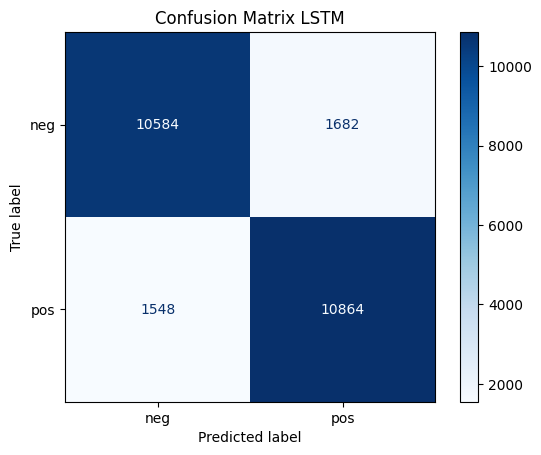

In [32]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_lstm.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix LSTM")
plt.show()

### III.3 GRU

In [33]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()

In [34]:
# 2. Construction du modèle RNN
model_gru = Sequential()

# Ajouter une couche SimpleRNN avec 64 unités
model_gru.add(GRU(128, activation='tanh',input_shape=(1, train_tfidf_dense.shape[1])))  # Première couche LSTM, return_sequences=True permet de passer les séquences à la couche suivante



# Dropout pour éviter le surapprentissage
model_gru.add(Dropout(0.2))

# Couche de sortie pour la classification binaire
model_gru.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# 3. Compilation du modèle
model_gru.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])


model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               1201920   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,202,049
Trainable params: 1,202,049
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 4. Reshaper les données d'entrée
train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))

start_time= time.time()
# 5. Entraînement du modèle
history=model_gru.fit(train_tfidf_dense, y_train,
          epochs=30, 
          batch_size=64, 
          validation_data=(val_tfidf_dense, y_val), 
          verbose=1)

end_time=time.time()

time_GRU=end_time - start_time

Epoch 1/30
282/282 [==============================] - 3s 7ms/step - loss: 0.6871 - accuracy: 0.6712 - val_loss: 0.6817 - val_accuracy: 0.7594
Epoch 2/30
282/282 [==============================] - 2s 6ms/step - loss: 0.6738 - accuracy: 0.7957 - val_loss: 0.6682 - val_accuracy: 0.8013
Epoch 3/30
282/282 [==============================] - 2s 6ms/step - loss: 0.6576 - accuracy: 0.8310 - val_loss: 0.6515 - val_accuracy: 0.8268
Epoch 4/30
282/282 [==============================] - 2s 6ms/step - loss: 0.6381 - accuracy: 0.8400 - val_loss: 0.6317 - val_accuracy: 0.8325
Epoch 5/30
282/282 [==============================] - 2s 6ms/step - loss: 0.6155 - accuracy: 0.8460 - val_loss: 0.6095 - val_accuracy: 0.8353
Epoch 6/30
282/282 [==============================] - 2s 6ms/step - loss: 0.5910 - accuracy: 0.8492 - val_loss: 0.5857 - val_accuracy: 0.8385
Epoch 7/30
282/282 [==============================] - 2s 6ms/step - loss: 0.5651 - accuracy: 0.8513 - val_loss: 0.5612 - val_accuracy: 0.8419
Epoch 

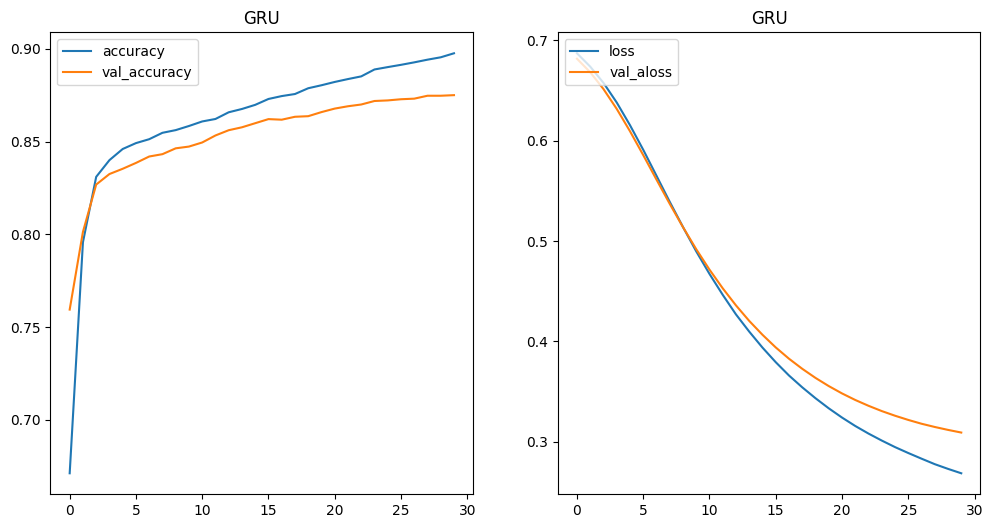

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("GRU")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_aloss')
plt.title("GRU")
plt.legend(loc='upper left')
plt.show()

In [37]:
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))

# Maintenant vous pouvez appeler le modèle avec les données correctement redimensionnées
loss_GRU, accuracy_GRU = model_gru.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Afficher les résultats
print(f"Test Loss: {loss_GRU:.4f}, Test Accuracy: {accuracy_GRU:.4f}")


772/772 [==============================] - 2s 3ms/step - loss: 0.3103 - accuracy: 0.8712
Test Loss: 0.3103, Test Accuracy: 0.8712


In [38]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_gru.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix GRU")
plt.show()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [40]:
duration["GRU"] = time_GRU
accuracy["GRU"] = accuracy_GRU

### III.4 MLP

In [41]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()
test_tfidf_dense = test_tfidf.toarray()

In [ ]:
# 2. Construction du modèle MLP
model_mlp = Sequential()

# Ajouter une couche d'entrée entièrement connectée avec 128 unités
model_mlp.add(Dense(128, activation='relu', input_dim=train_tfidf_dense.shape[1]))  # Entrée dense, avec ReLU

# Dropout pour éviter le surapprentissage
model_mlp.add(Dropout(0.2))

# Couche de sortie pour la classification binaire
model_mlp.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# 3. Compilation du modèle
model_mlp.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

model_mlp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               384128    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 384,257
Trainable params: 384,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
# val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))

# 4. Entraînement du modèle MLP
start_time_mlp = time.time()

history_mlp = model_mlp.fit(train_tfidf_dense, y_train,
                            epochs=30, 
                            batch_size=64, 
                            validation_data=(val_tfidf_dense, y_val), 
                            verbose=1)

end_time_mlp = time.time()

# Durée de l'entraînement
time_mlp = end_time_mlp - start_time_mlp


Epoch 1/30
331/331 [==============================] - 2s 4ms/step - loss: 0.6881 - accuracy: 0.6327 - val_loss: 0.6817 - val_accuracy: 0.7586
Epoch 2/30
331/331 [==============================] - 1s 4ms/step - loss: 0.6704 - accuracy: 0.7940 - val_loss: 0.6594 - val_accuracy: 0.8134
Epoch 3/30
331/331 [==============================] - 1s 4ms/step - loss: 0.6398 - accuracy: 0.8316 - val_loss: 0.6259 - val_accuracy: 0.8351
Epoch 4/30
331/331 [==============================] - 1s 4ms/step - loss: 0.6025 - accuracy: 0.8451 - val_loss: 0.5899 - val_accuracy: 0.8402
Epoch 5/30
331/331 [==============================] - 1s 4ms/step - loss: 0.5646 - accuracy: 0.8525 - val_loss: 0.5555 - val_accuracy: 0.8445
Epoch 6/30
331/331 [==============================] - 1s 4ms/step - loss: 0.5297 - accuracy: 0.8569 - val_loss: 0.5243 - val_accuracy: 0.8461
Epoch 7/30
331/331 [==============================] - 1s 4ms/step - loss: 0.4986 - accuracy: 0.8620 - val_loss: 0.4964 - val_accuracy: 0.8514
Epoch 

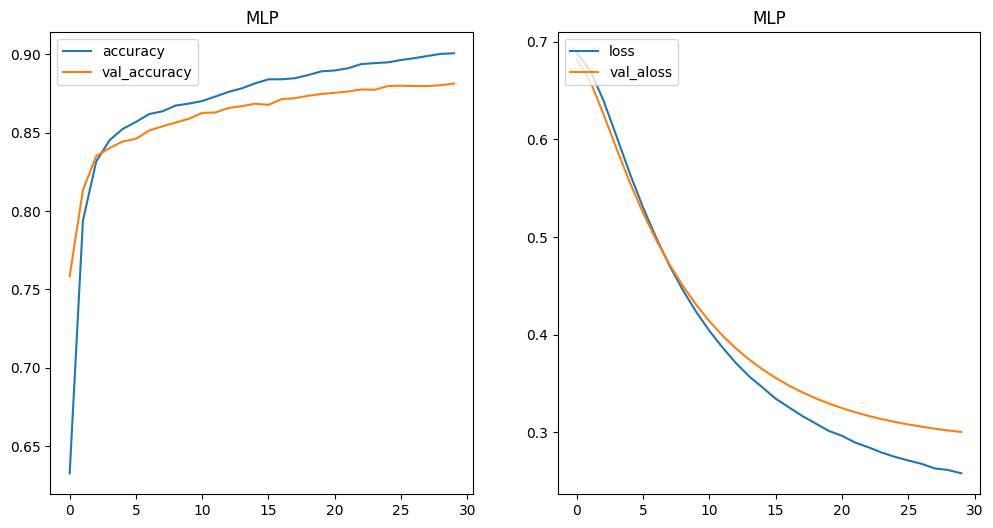

In [44]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history_mlp.history['accuracy'], label='accuracy')
plt.plot(history_mlp.history['val_accuracy'], label = 'val_accuracy')
plt.title("MLP")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history_mlp.history['loss'], label='loss')
plt.plot(history_mlp.history['val_loss'], label = 'val_aloss')
plt.title("MLP")
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Maintenant vous pouvez appeler le modèle avec les données correctement redimensionnées
loss_MLP, accuracy_MLP = model_mlp.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Afficher les résultats
print(f"Test Loss: {loss_MLP:.4f}, Test Accuracy: {accuracy_MLP:.4f}")


772/772 [==============================] - 2s 2ms/step - loss: 0.2991 - accuracy: 0.8753
Test Loss: 0.2991, Test Accuracy: 0.8753


772/772 [==============================] - 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12266
           1       0.87      0.88      0.88     12412

    accuracy                           0.88     24678
   macro avg       0.88      0.88      0.88     24678
weighted avg       0.88      0.88      0.88     24678



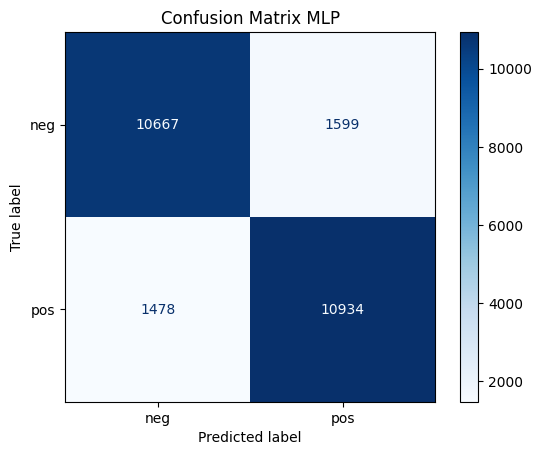

In [ ]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_mlp.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix MLP")
plt.show()

In [47]:
duration["MLP"] = time_mlp
accuracy["MLP"] = accuracy_MLP

### III.5 Conv1D

In [48]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()

In [ ]:

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
# 2. Construction du modèle Conv1D
model_conv1d = Sequential()

# Ajouter une couche de convolution 1D
model_conv1d.add(Conv1D(64, 5, activation='relu', input_shape=(train_tfidf_dense.shape[1], 1)))  # 64 filtres, taille de noyau = 5

# Ajouter une couche de pooling pour réduire les dimensions
model_conv1d.add(MaxPooling1D(pool_size=2))  # Pooling avec une taille de 2

# Applatissement de la sortie pour la connecter à des couches denses
model_conv1d.add(Flatten())

# Dropout pour éviter le surapprentissage
model_conv1d.add(Dropout(0.2))

# Ajouter une couche entièrement connectée
model_conv1d.add(Dense(64, activation='relu'))

# Couche de sortie pour la classification binaire
model_conv1d.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# 3. Compilation du modèle
model_conv1d.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model_conv1d.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2996, 64)          384       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1498, 64)         0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 95872)             0         
                                                                 
 dropout_6 (Dropout)         (None, 95872)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                6135872   
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
# Reshape train and validation data for Conv1D
train_tfidf_dense_reshaped = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], train_tfidf_dense.shape[1], 1))  # Adding the third dimension (1 feature per word)
val_tfidf_dense_reshaped = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], val_tfidf_dense.shape[1], 1))

# Start training the model
start_time_conv1d = time.time()

history_conv1d = model_conv1d.fit(train_tfidf_dense_reshaped, y_train,
                                  epochs=20, 
                                  batch_size=16, 
                                  validation_data=(val_tfidf_dense_reshaped, y_val), 
                                  verbose=1)

end_time_conv1d = time.time()

# Store the training time for Conv1D
time_conv1d = end_time_conv1d - start_time_conv1d


Epoch 1/20
1323/1323 [==============================] - 8s 6ms/step - loss: 0.5577 - accuracy: 0.7953 - val_loss: 0.4523 - val_accuracy: 0.8274
Epoch 2/20
1323/1323 [==============================] - 8s 6ms/step - loss: 0.3893 - accuracy: 0.8464 - val_loss: 0.3734 - val_accuracy: 0.8450
Epoch 3/20
1323/1323 [==============================] - 8s 6ms/step - loss: 0.3358 - accuracy: 0.8597 - val_loss: 0.3459 - val_accuracy: 0.8539
Epoch 4/20
1323/1323 [==============================] - 8s 6ms/step - loss: 0.3097 - accuracy: 0.8714 - val_loss: 0.3330 - val_accuracy: 0.8632
Epoch 5/20
1323/1323 [==============================] - 8s 6ms/step - loss: 0.2934 - accuracy: 0.8774 - val_loss: 0.3255 - val_accuracy: 0.8656
Epoch 6/20
1323/1323 [==============================] - 8s 6ms/step - loss: 0.2812 - accuracy: 0.8822 - val_loss: 0.3314 - val_accuracy: 0.8611
Epoch 7/20
1323/1323 [==============================] - 8s 6ms/step - loss: 0.2730 - accuracy: 0.8848 - val_loss: 0.3181 - val_accuracy:

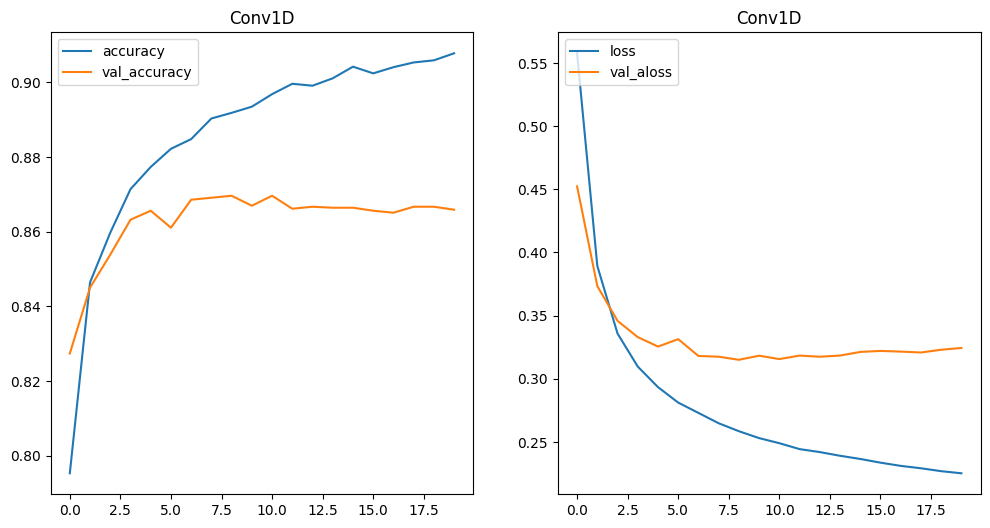

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history_conv1d.history['accuracy'], label='accuracy')
plt.plot(history_conv1d.history['val_accuracy'], label = 'val_accuracy')
plt.title("Conv1D")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history_conv1d.history['loss'], label='loss')
plt.plot(history_conv1d.history['val_loss'], label = 'val_aloss')
plt.title("Conv1D")
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Reshape test data for Conv1D (3D)
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], test_tfidf.toarray().shape[1], 1))

# Convert labels to numpy array (if they are in pandas DataFrame)
y_test = test_df['label'].to_numpy()

# Now you can evaluate the model with the correctly shaped data
loss_conv1d, accuracy_conv1d = model_conv1d.evaluate(test_tfidf_dense, y_test, verbose=1)

# Display the results
print(f"Test Loss: {loss_conv1d:.4f}, Test Accuracy: {accuracy_conv1d:.4f}")


772/772 [==============================] - 4s 4ms/step - loss: 0.6900 - accuracy: 0.6951
Test Loss: 0.6900, Test Accuracy: 0.6951


772/772 [==============================] - 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12266
           1       0.86      0.87      0.86     12412

    accuracy                           0.86     24678
   macro avg       0.86      0.86      0.86     24678
weighted avg       0.86      0.86      0.86     24678



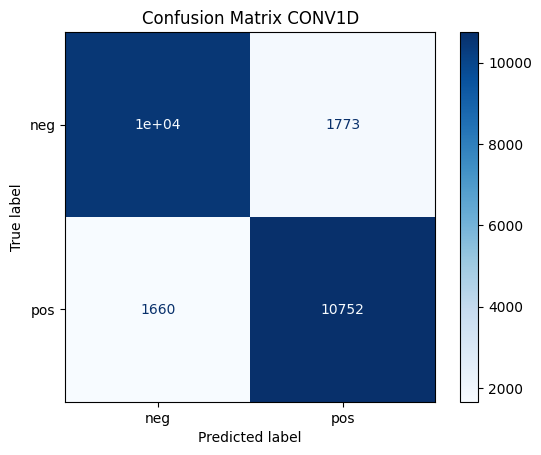

In [ ]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_conv1d.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix CONV1D")
plt.show()

In [62]:
duration["CONV1D"] = time_conv1d
accuracy["CONV1D"] = accuracy_conv1d

## IV Comparaison 


Text(0.5, 1.0, 'Accuracy par modele')

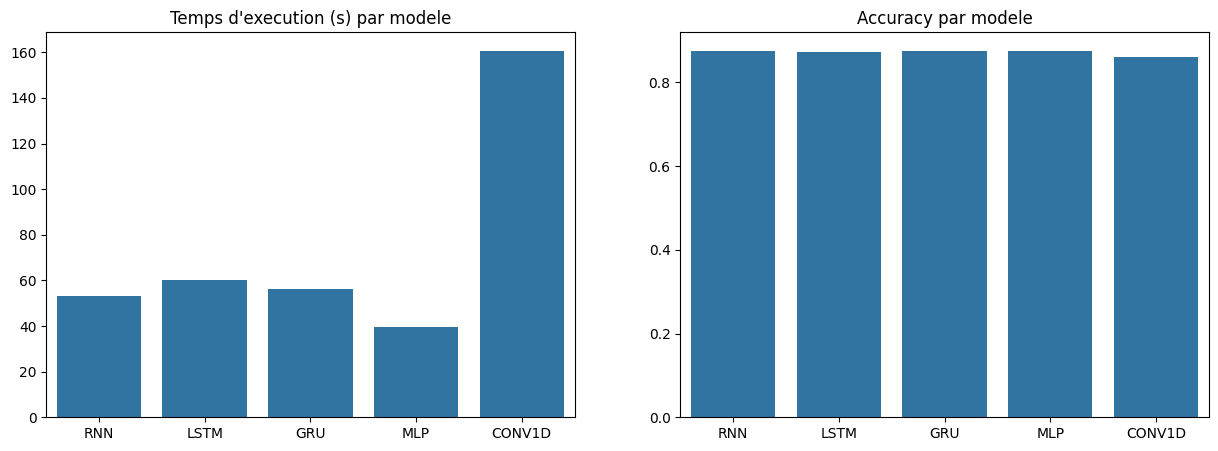

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(duration)
plt.title("Temps d'execution (s) par modele")
plt.subplot(122)
sns.barplot(accuracy)
plt.title("Accuracy par modele")

## V. Assemblage des modeles

772/772 [==============================] - 1s 1ms/step


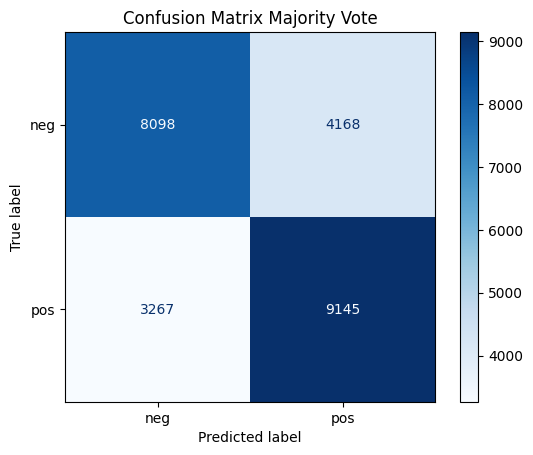

In [19]:
from sklearn.metrics import accuracy_score

# Assuming `model_rnn`, `model_lstm`, `model_gru`, `model_conv1d`, and `model_mlp`
# have been trained and the corresponding test data is available
test_tfidf_densegru = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))
# Step 1: Make predictions for each model
y_pred_rnn = (model_rnn.predict(test_tfidf_densegru) > 0.5).astype(int)
y_pred_lstm = (model_lstm.predict(test_tfidf_densegru) > 0.5).astype(int)
y_pred_gru = (model_gru.predict(test_tfidf_densegru) > 0.5).astype(int)
y_pred_conv1d = (model_conv1d.predict(test_tfidf_dense) > 0.5).astype(int)
y_pred_mlp = (model_mlp.predict(test_tfidf_dense) > 0.5).astype(int)

# Step 2: Stack predictions from all models
predictions_stack = np.stack([y_pred_rnn, y_pred_lstm, y_pred_gru, y_pred_conv1d, y_pred_mlp], axis=0)

# Step 3: Apply majority voting (mode of the predictions)
# Each row corresponds to one test sample, and the majority vote is calculated across the models
ensemble_predictions = np.squeeze(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_stack))

# Step 4: Evaluate the ensemble
accuracy_ensemble = accuracy_score(test_df['label'], ensemble_predictions)
# Confusion matrix
cm = confusion_matrix(test_df['label'], ensemble_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Majority Vote")
plt.show()


In [ ]:
accuracy["MV"] = accuracy_ensemble
sns.barplot(accuracy)

TypeError: 'float' object does not support item assignment

In [300]:
val_df.duplicated().sum()

0

In [73]:
# Sauvegarde des DataFrames en CSV
train_df.to_csv("train_data.csv", index=False, encoding='utf-8')
test_df.to_csv("test_data.csv", index=False, encoding='utf-8')
unlabeled_data.to_csv("unlabeled_data.csv", index=False, encoding='utf-8')


In [74]:
train_df.shape

(21168, 2)

In [75]:
# Create a directory to save the models if it doesn't exist
import os
os.makedirs("saved_models", exist_ok=True)

# Save each model
model_rnn.save("saved_models/model_rnn.h5")
model_lstm.save("saved_models/model_lstm.h5")
model_gru.save("saved_models/model_gru.h5")
model_mlp.save("saved_models/model_mlp.h5")
model_conv1d.save("saved_models/model_conv1d.h5")

print("All models have been saved successfully!")


All models have been saved successfully!


In [15]:
from tensorflow.keras.models import load_model

# Load each model
model_rnn = load_model("saved_models/model_rnn.h5")
model_lstm = load_model("saved_models/model_lstm.h5")
model_gru = load_model("saved_models/model_gru.h5")
model_mlp = load_model("saved_models/model_mlp.h5")
model_conv1d = load_model("saved_models/model_conv1d.h5")

print("All models have been loaded successfully!")


All models have been loaded successfully!
